In [34]:

import time

start_time = time.time()


In [35]:

import pandas as pd
df = pd.read_csv('adult.data', sep=',', header=None) #training data


column_names = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status","occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "agrossincome"]  # Replacing numbers with var names for easier readibility and interpretation
df.columns = column_names


In [36]:
df.dtypes #check

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
agrossincome      object
dtype: object

In [37]:
df.describe(include='object') #check

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,agrossincome
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [38]:
df.columns = df.columns.str.strip()  # Remove any leading/trailing spaces
print(df.columns)


if 'agrossincome' in df.columns:
    Y = df['agrossincome']
else:
    print("Column 'agrossincome' still not found after stripping. Available columns:", df.columns)


Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'agrossincome'],
      dtype='object')


In [39]:
test_data = pd.read_csv('adult.test', sep=',', header=None)   #Note: The first line |1x3 Cross validator has been revmoed from the dataset prior to loading and preprocessing
test_data.columns = column_names
test_data.dtypes #check

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
agrossincome      object
dtype: object

In [40]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import optuna
import warnings
from sklearn.model_selection import cross_val_score




# Define column names
column_names = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", 
                "hours-per-week", "native-country", "agrossincome"]

# Assign column names to the dataframe
df.columns = column_names
test_data.columns = column_names  # Apply the same column names to test data

# Separate features (X) and target (y) for training data
X_train = df.drop(columns='agrossincome')
y_train = df['agrossincome'].str.strip()  # Remove leading/trailing spaces from target

# Separate features (X) and target (y) for test data
X_test = test_data.drop(columns='agrossincome')
y_test = test_data['agrossincome'].str.strip()  # Remove leading/trailing spaces from target


# Ensure there are no inconsistencies in labels (e.g., extra punctuation or spaces)
y_train = y_train.replace({r'\.$': ''}, regex=True)
y_test = y_test.replace({r'\.$': ''}, regex=True)


# Encode target variable as categorical
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Identify categorical columns
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 
                       'relationship', 'race', 'sex', 'native-country']

# Use OneHotEncoder to transform categorical columns
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(), categorical_columns)], remainder='passthrough')

# Preprocess the features (apply OneHotEncoder to categorical variables)
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    max_depth = trial.suggest_categorical('max_depth', [2, 4, 8, 10, 12, None])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_features = trial.suggest_float('max_features', 0.25, 1.0)
    min_samples_split = trial.suggest_float('min_samples_split', 0.01, 0.25)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    # Create and train the model
    model = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion, max_features=max_features,
                                    min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    model.fit(X_train_preprocessed, y_train_encoded)

    # Evaluate the model with cross-validation
    cv_scores = cross_val_score(model, X_train_preprocessed, y_train_encoded, cv=3)
    return cv_scores.mean()
    
    # Evaluate the model
    return model.score(X_test_preprocessed, y_test_encoded)

 

# Create and run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Number of trials can be adjusted

# Retrieve the best parameters
best_params = study.best_params
print(f"Best Parameters: {best_params}")
print(f"Best Test Accuracy: {study.best_value:.2f}")


c:\Users\annma\anaconda3\envs\new_env_name\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-10-12 23:49:27,690] A new study created in memory with name: no-name-469de86c-f356-4597-a2c0-a10c789858e3
[I 2024-10-12 23:49:27,962] Trial 0 finished with value: 0.8449065744169054 and parameters: {'max_depth': 4, 'criterion': 'entropy', 'max_features': 0.9472825588558998, 'min_samples_split': 0.2228075898589283, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8449065744169054.
[I 2024-10-12 23:49:28,120] Trial 1 finished with value: 0.8111855229485084 and parameters: {'max_depth': 2, 'criterion': 'entropy', 'max_features': 0.5510836713439665, 'min_samples_split': 0.09283905122173523, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8449065744169054.
[I 2024-10-12 23:49:28,681] Trial 2 finished with value

Best Parameters: {'max_depth': None, 'criterion': 'gini', 'max_features': 0.7297711985007441, 'min_samples_split': 0.01758425708599958, 'min_samples_leaf': 6}
Best Test Accuracy: 0.86


Test accuracy of the pruned model: 86.00%
Model accuracy from final cross-validation:  0.8551643597293599


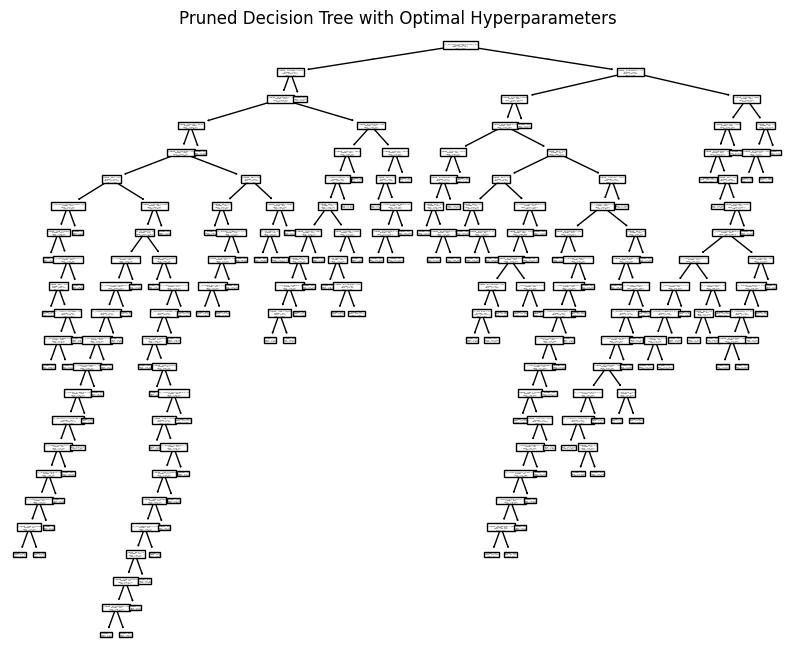

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     12435
           1       0.76      0.59      0.67      3846

    accuracy                           0.86     16281
   macro avg       0.82      0.77      0.79     16281
weighted avg       0.85      0.86      0.85     16281



In [41]:
import numpy as np

# Train the model with the best parameters found
best_model = DecisionTreeClassifier(**best_params)
best_model.fit(X_train_preprocessed, y_train_encoded)

# Perform cost complexity pruning
path = best_model.cost_complexity_pruning_path(X_train_preprocessed, y_train_encoded)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Loop through ccp_alphas to find the best alpha for pruning
pruned_models = []
train_scores = []
test_scores = []

for ccp_alpha in ccp_alphas:
    pruned_model = DecisionTreeClassifier(ccp_alpha=ccp_alpha, **best_params)
    pruned_model.fit(X_train_preprocessed, y_train_encoded)
    
    # Evaluate on the training set
    train_scores.append(pruned_model.score(X_train_preprocessed, y_train_encoded))
    
    # Evaluate on the test set
    test_scores.append(pruned_model.score(X_test_preprocessed, y_test_encoded))
    
    pruned_models.append(pruned_model)

# Find the index of the model with the best test accuracy
best_index = test_scores.index(max(test_scores))
optimal_ccp_alpha = ccp_alphas[best_index]

# Train the pruned model with the optimal ccp_alpha
pruned_model = DecisionTreeClassifier(ccp_alpha=optimal_ccp_alpha, **best_params)
pruned_model.fit(X_train_preprocessed, y_train_encoded)

# Evaluate on the test set
test_accuracy = pruned_model.score(X_test_preprocessed, y_test_encoded)
print(f"Test accuracy of the pruned model: {test_accuracy * 100:.2f}%")

# Perform 3-fold cross-validation on the preprocessed training data
final_cv_scores = cross_val_score(pruned_model, X_train_preprocessed, y_train_encoded, cv=3)

# Print the average accuracy from final cross-validation
print('Model accuracy from final cross-validation: ', np.mean(final_cv_scores))

# Plot the decision tree for the pruned model
plt.figure(figsize=(10, 8))
plot_tree(pruned_model, feature_names=preprocessor.get_feature_names_out(), class_names=label_encoder.classes_, impurity=False)
plt.title("Pruned Decision Tree with Optimal Hyperparameters")
plt.show()

# Generate a classification report on the test set
y_test_pred = pruned_model.predict(X_test_preprocessed)
print(classification_report(y_test_encoded, y_test_pred))

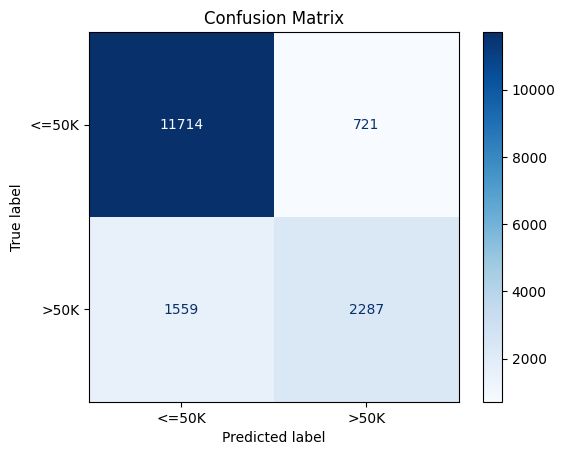

In [42]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_encoded, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [43]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total time spent: {total_time:.2f} seconds")

Total time spent: 71.43 seconds
